# Postprocessing

In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import glob
import seaborn as sns 
import os
from matplotlib.colors import to_hex
from pathlib import Path
import sys

project_root = Path.cwd().parents[0]
sys.path.append(str(project_root))

from utils.plotting import create_figure, palette, colorwheel, customize_axis, get_figure_dimensions
from utils.bathymetry import generate_bathymetry
from utils.config import load_config, default_params
from utils.io import read_raw_output
from utils.grid import prepare_dsH, interp_ds

In [2]:
figpath = "../figures/"

## Read in base cases

In [3]:
# read simulation output
params_L = load_config("../configs/baseline_forcing/long.json")
ds_L = read_raw_output(params_L)
params_S = load_config("../configs/baseline_forcing/short.json")
ds_S = read_raw_output(params_S)

Loading configuration from ../configs/baseline_forcing/long.json
Loading configuration from ../configs/baseline_forcing/short.json


In [4]:
ds_L

<xarray.Dataset>
Dimensions:    (xC: 90, yF: 91, xF: 90, yC: 90, time: 3073)
Coordinates:
  * xC         (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yF         (yF) float64 0.0 1e+03 2e+03 3e+03 ... 8.8e+04 8.9e+04 9e+04
  * xF         (xF) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
  * yC         (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 384 days 00:00:00
Data variables:
    v          (time, yF, xC) float64 ...
    duvhdy     (time, yF, xF) float64 ...
    zetau      (time, yF, xF) float64 ...
    zetav      (time, yF, xF) float64 ...
    u          (time, yC, xF) float64 ...
    zeta       (time, yF, xF) float64 ...
    detadx     (time, yC, xF) float64 ...
    h          (time, yC, xC) float64 ...
    bath       (yC, xC) float64 100.1 100.1 100.1 100.1 ... 899.9 899.9 899.9
    forcing_x  (time, yC, xC) float64 3.067e-07 3.067e-07 ... 3.067e-07
    forcing_y  (time, yC, xC) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.95.5
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-08-28T17:12:19.604.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

### Bathymetry

In [5]:
from utils.plotting import plot_3D_bathymetry, add_surface_contours3d, plot_bathymetry, add_bathymetry_contours

In [6]:
# select target depths for contours
H_targets = ds_L.bath.mean("xC").values

# focus depth contour will be in the middle of the slope
focus_j = 45

H_targets[50]

670.4287047259253

In [7]:
X, Y, h = generate_bathymetry(default_params, full=True)

# m to km
X /= 1e3
Y /= 1e3

fig = plot_3D_bathymetry(X, Y, h, 
                         width="single", 
                         aspect_ratio=0.5
                         )

add_surface_contours3d(
    fig, X, Y, h, H_targets,
    color="rgba(140,140,140,0.9)",
    width=3,
    eps="auto"
)

add_surface_contours3d(
    fig, X, Y, h, [H_targets[focus_j]],
    #color=palette["accesnt1"],
    width=9,
    eps="auto"
)

fig.write_image(figpath+"3dbath.pdf")
#fig

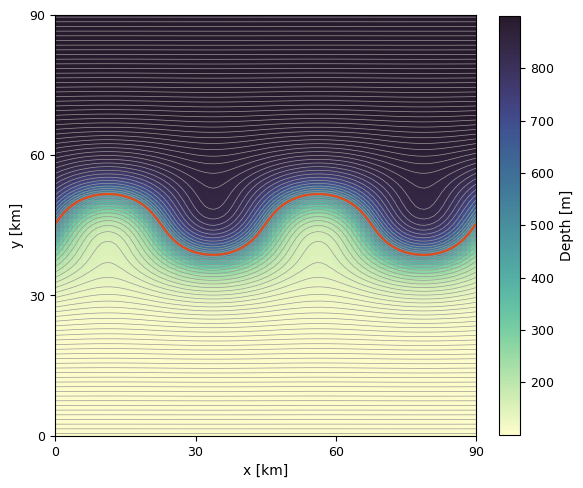

In [12]:
fig, ax = create_figure("single", aspect_ratio=1.0)

img = plot_bathymetry(ax, X, Y, h)
fig.colorbar(img, ax=ax, label="Depth [m]", fraction=0.045)
ax.set_aspect("equal", adjustable="box")

# thin grey contours
add_bathymetry_contours(ax, X, Y, h, H_targets, color="0.6", linewidth=0.5)

# highlight one contour
add_bathymetry_contours(ax, X, Y, h, [H_targets[focus_j]], linewidth=1.5)


fig.savefig(figpath+"2dbath.pdf", bbox_inches="tight")

## Analysis on depth conturs

In [9]:
# interpolate dataset onto the selected depth-contours
dsH_L = prepare_dsH(ds_L, params_L, H_targets)
dsH_S = prepare_dsH(ds_S, params_S, H_targets)

dsH_L

<xarray.Dataset>
Dimensions:    (time: 3073, j: 90, i: 120)
Coordinates:
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 384 days 00:00:00
    x          (j, i) float64 4.5e+04 4.519e+04 4.538e+04 ... 4.481e+04 4.5e+04
    y          (j, i) float64 500.0 500.1 500.2 ... 8.95e+04 8.95e+04 8.95e+04
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Data variables: (12/18)
    v          (time, j, i) float64 0.0 0.0 0.0 ... -3.985e-05 -4.261e-05
    duvhdy     (time, j, i) float64 0.0 0.0 0.0 ... -3.558e-06 -3.806e-06
    zetau      (time, j, i) float64 0.0 0.0 0.0 ... 2.865e-11 2.855e-11
    zetav      (time, j, i) float64 0.0 0.0 0.0 ... 2.294e-14 2.445e-14
    u          (time, j, i) float64 0.0 0.0 0.0 ... -0.09875 -0.09876 -0.09878
    zeta       (time, j, i) float64 0.0 0.0 0.0 ... -2.901e-10 -2.891e-10
    ...         ...
    forcing_i  (time, j, i) float64 -3.067e-07 3.067e-07 ... -3.067e-07
    zetaflux   (time, j, i) float64 -0.0 0.0 0.0 ... 1.006e-14 -2.455e-14
    dtx        (j, i) float64 -1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 -1.0
    dty        (j, i) float64 3.809e-06 0.0004495 ... 0.0004495 3.809e-06
    dl         (j, i) float64 1.116e+04 189.1 189.1 ... 189.1 189.1 1.116e+04
    depth      (j) float64 100.1 100.1 100.1 100.1 ... 899.9 899.9 899.9 899.9
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.95.5
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-08-28T17:12:19.604.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

In [10]:
def mean_onH(dsH, variable):
    """Compute mean of variable along depth-following contours (H-contours)."""
    return (dsH[variable] * dsH.dl).sum("i") / dsH.dl.sum("i")

def calculate_analytical_estimates_xr(
    ds: xr.Dataset,
    forcing_vars: list[str],
    params: dict,
) -> xr.DataArray:
    """
    y(t_j) = ∫_0^{t_j} exp[-(R/H(j)) * (t_j - τ)] * F(τ, j) dτ
    One-pass recurrence (left Riemann per step) with constant Δt = params["outputtime"].
    Recurrence: y_i = decay * y_{i-1} + alpha * F_{i-1},
    where decay = exp(-k*Δt), alpha = (1 - decay)/k, k = R/H(j).
    """
    R = float(params["R"])
    dt = float(params["outputtime"]) 

    H = ds["depth"]  
    
    # Sum forcing fields (must have dims include "time" and "j")
    F = sum(ds[v] for v in forcing_vars)

    t = ds["time"]
    nT = t.sizes["time"]
    if nT == 0:
        raise ValueError("Empty time axis.")
    if nT == 1:
        return xr.zeros_like(F)

    # k(j) = R/H(j), broadcast over all non-time dims of F
    k = (R / H).broadcast_like(F.isel(time=0))

    # Precompute coefficients (constant in time)
    decay = np.exp(-k * dt)
    # Safe alpha for k≈0: limit -> dt
    alpha = xr.where(np.abs(k) > 0, (1.0 - decay) / k, dt)

    # build y 
    y0 = xr.zeros_like(F.isel(time=0, drop=True))
    ys = [y0]
    for i in range(1, nT):
        Fi_1 = F.isel(time=i - 1, drop=True)  # drop time here too
        y_next = decay * ys[-1] + alpha * Fi_1
        ys.append(y_next)
    y = xr.concat(ys, dim="time").assign_coords(time=t) / H

    return y

In [11]:
for dsH, params in zip([dsH_L, dsH_S], [params_L, params_S]):
    # diagnose circulation
    dsH["circulation"] = mean_onH(dsH, variable="ui")
    
    # calculate momentum terms
    dsH["BS"] = -dsH.circulation*params["R"]
    dsH["TFS"] = dsH.circulation*0
    dsH["MFC"] = mean_onH(dsH, variable="zetaflux") * dsH.depth
    dsH["SS"] = mean_onH(dsH, variable="forcing_i") 
    
    # circulation estimates
    dsH["linear_estimate"] = calculate_analytical_estimates_xr(dsH, ["SS"], params)
    dsH["nonlinear_estimate"] = calculate_analytical_estimates_xr(dsH, ["SS", "MFC"], params)

In [12]:
# We will focus on 128 days of simulations
focus_time_start_L = -(128+64)*8
focus_time_stop_L = -64*8

focus_time_start_S = -(128+8)*8
focus_time_stop_S = -8*8

# # store a time series that is a bit longer. Will use this for EKE calculaitons
# dsH_Ll = dsH_L.isel(time=slice(focus_time_start_L-30*8,focus_time_stop_L+30*8))
# dsH_Sl = dsH_S.isel(time=slice(focus_time_start_S-30*8,focus_time_stop_S))

# For other analyses, focus on the spesified time interval
dsH_L= dsH_L.isel(time=slice(focus_time_start_L,focus_time_stop_L))
dsH_S = dsH_S.isel(time=slice(focus_time_start_S,focus_time_stop_S))

#adjust time index so that t=0 is the beginning of the focus period
t0_L = dsH_L.time.isel(time=0)
t0_S = dsH_S.time.isel(time=0)


dsH_L["time"] = dsH_L.time - t0_L
dsH_S["time"] = dsH_S.time - t0_S

# dsH_Ll["time"] = dsH_Ll.time - t0_L
# dsH_Sl["time"] = dsH_Sl.time - t0_S

### Scatterplots

In [13]:
from utils.plotting import plot_scatter

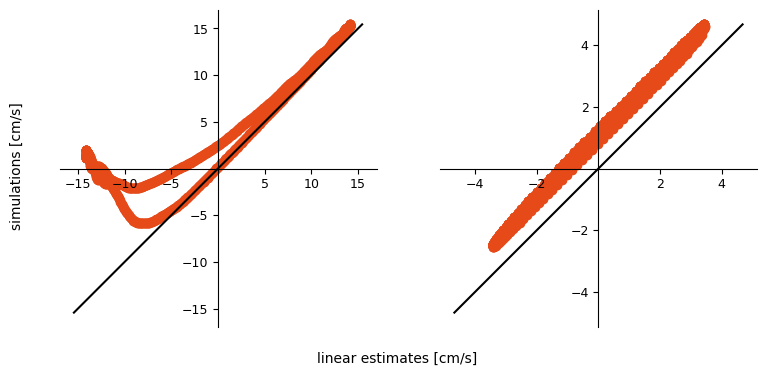

In [14]:
xL = dsH_L.isel(j=focus_j).linear_estimate*1e2
yL = dsH_L.isel(j=focus_j).circulation*1e2

# x = long_dsH.isel(j=slice(35,55)).linear_circulation.values.flatten()
# y = long_dsH.isel(j=slice(35,55)).circulation.values.flatten()

fig, [axL,axS] = create_figure(
    "double", ncols=2
    #"single", aspect_ratio=1.8, nrows=2
    )
plot_scatter(axL, xL, yL)


xS = dsH_S.isel(j=focus_j).linear_estimate*1e2
yS = dsH_S.isel(j=focus_j).circulation*1e2

# x = short_dsH.isel(j=slice(35,55)).linear_circulation.values.flatten()
# y = short_dsH.isel(j=slice(35,55)).circulation.values.flatten()

plot_scatter(axS, xS, yS)

fig.supxlabel('linear estimates [cm/s]', 
              x=0.5, y=0.1, 
              fontsize=10
              )
fig.supylabel('simulations [cm/s]', 
              x=0.07, y=0.5, 
              fontsize=10
              )


ticksL = [-15, -10, -5, 5, 10, 15]
axL.set_yticks(ticksL)
axL.set_xticks(ticksL)

ticksS = [-4, -2, 2, 4]
axS.set_yticks(ticksS)
axS.set_xticks(ticksS)

fig.savefig(figpath+"scatterplots.pdf", bbox_inches="tight")

### Timeseries

In [15]:
from utils.plotting import plot_circulation_timeseries

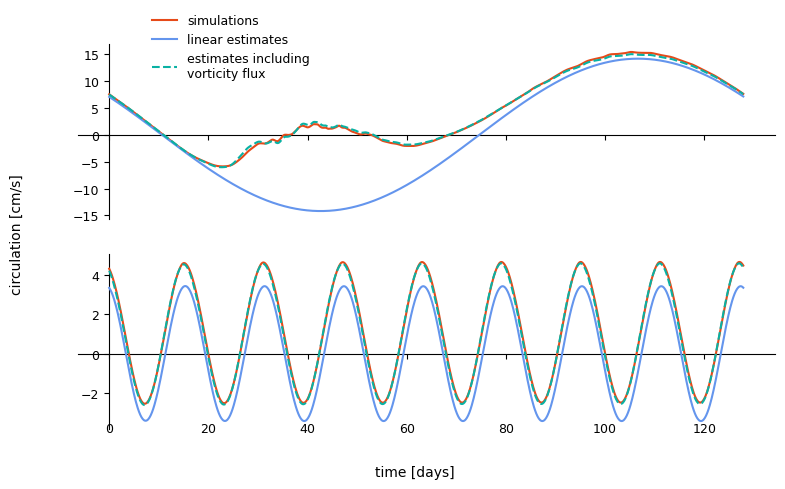

In [16]:
tsL = dsH_L.isel(j=focus_j)
tsS = dsH_S.isel(j=focus_j)

fig, [axt,axb] = create_figure("double", nrows=2, 
                               sharex =True
                               )

plot_circulation_timeseries(axt, tsL)
plot_circulation_timeseries(axb, tsS)

fig.supxlabel('time [days]', 
              x=0.5, y=0.01, 
              fontsize=10
              )
fig.supylabel('circulation [cm/s]', 
              x=0.05, y=0.5, 
              fontsize=10
              )

axt.legend(
    loc="upper left", 
    bbox_to_anchor=(0.1, 1.2),  # shift legend outside
    borderaxespad=0,           # tighter to plot
    frameon=False              # no border
)

# Shift x-axis tick labels downward
for label in axb.get_xticklabels():
    label.set_y(label.get_position()[1] - 3)

fig.savefig(figpath+"timeseries_circulation.pdf", bbox_inches="tight")

### Momentum diagrams

In [17]:
from utils.plotting import initialize_momentum_diagrams

In [18]:
ystart = 20
ystop = 70

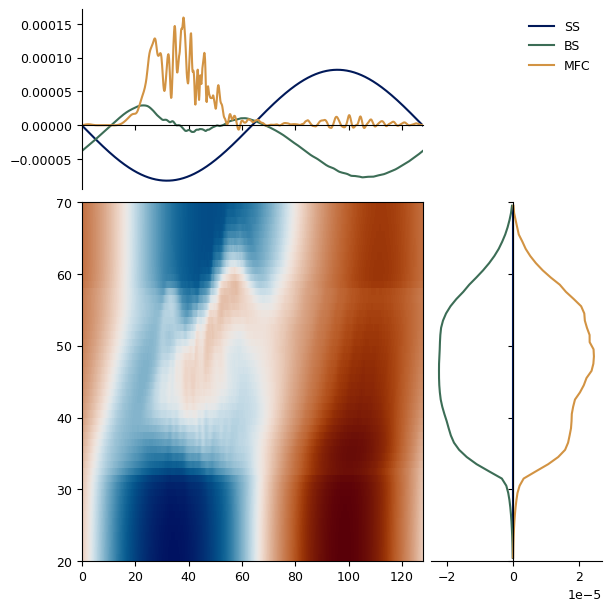

In [19]:
fig, axd = initialize_momentum_diagrams()

tdays = dsH_L.time / np.timedelta64(1, "D")
equivY = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3 
vlim = np.max(np.abs(dsH_L.isel(j=slice(ystart, ystop)).circulation))

axd["circ"].pcolormesh(tdays, equivY,  dsH_L.isel(j=slice(ystart, ystop)).circulation.T, 
                       vmin = -vlim,
                       vmax=vlim,
                       cmap=palette["cmdiv"])

for i, term in enumerate(["SS", "BS", "MFC"]):
    tmean = dsH_L[term].isel(j=slice(ystart, ystop)).mean("time")
    axd["tmean"].plot(tmean, equivY, color=colorwheel[i])
    
    for j, ls in zip([45], ["-"]):
        yval = dsH_L[term].sel(j=j)
        axd["ymean"].plot(tdays, yval, color=colorwheel[i], ls=ls)
    
    axd["legend"].plot([None, None], [None, None], label=term,color=colorwheel[i])

    

axd["legend"].axis("off")
axd["legend"].legend(loc='upper right', 
                    frameon=False,
                )

fig.savefig(figpath+"Hmomentum_L.pdf", bbox_inches="tight")

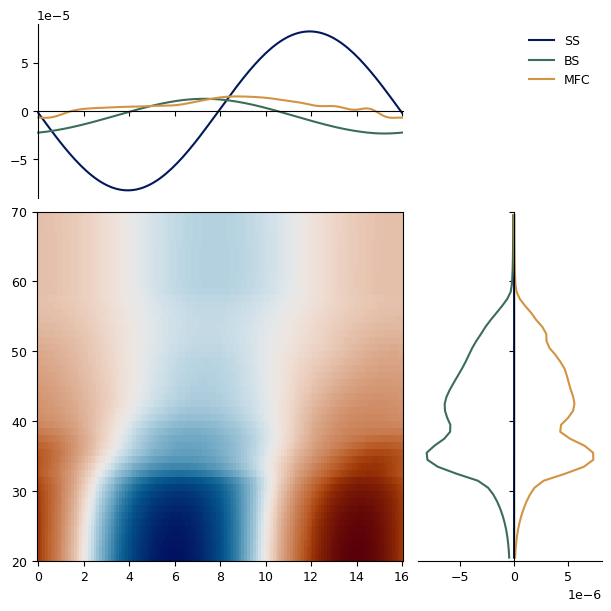

In [20]:
fig, axd = initialize_momentum_diagrams()

dsH_Sp = dsH_S.isel(time=slice(-16*8-1, None),j=slice(ystart, ystop))
dsH_Sp["time"] = dsH_Sp["time"]-dsH_Sp["time"].isel(time=0)

tdays = dsH_Sp.time / np.timedelta64(1, "D")
equivY = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3 
vlim = np.max(np.abs(dsH_Sp.circulation))


axd["circ"].pcolormesh(tdays, equivY,  dsH_Sp.circulation.T, 
                       vmin=-vlim,
                       vmax=vlim,
                       cmap=palette["cmdiv"]
                       )

for i, term in enumerate(["SS", "BS", "MFC"]):
    tmean = dsH_Sp[term].mean("time")
    axd["tmean"].plot(tmean, equivY, color=colorwheel[i])
    
    for j, ls in zip([45], ["-"]):
        yval = dsH_Sp[term].sel(j=j)
        axd["ymean"].plot(tdays, yval, color=colorwheel[i], ls=ls)
        
    axd["legend"].plot([None, None], [None, None], label=term,color=colorwheel[i])
    

axd["legend"].axis("off")
axd["legend"].legend(loc='upper right', 
                    frameon=False,
                )

fig.savefig(figpath+"Hmomentum_S.pdf", bbox_inches="tight")

### Individual momentum terms

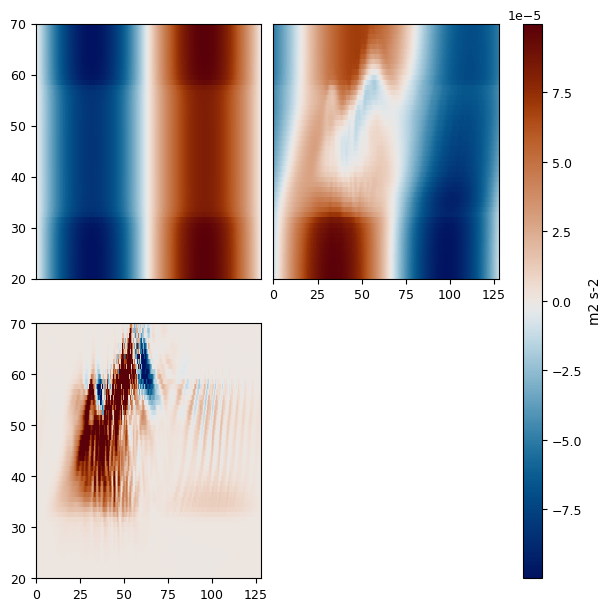

In [21]:
(fig_width_in, fig_height_in), _ = get_figure_dimensions("single", aspect_ratio=1)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))
axd = fig.subplot_mosaic(
    [
        ["0", "1", "cb"],
        ["2", "C", "cb"],
    ],
    width_ratios=[12, 12, 1],
    #sharex=True,
    #sharey=True
)

    
terms = ["SS", "BS", "MFC"]
vmax = np.max([np.abs(dsH_L[term]).quantile(0.98) for term in terms])
tdays = dsH_L.time / np.timedelta64(1,"D")

axes = [axd[f"{i}"] for i in range(3)]
for term, ax in zip(terms, axes):
    cm = ax.pcolormesh(tdays, equivY, dsH_L.isel(j=slice(ystart,ystop))[term].T, vmin=-vmax, 
                  vmax=vmax, 
                  cmap=palette["cmdiv"]
                  )

axd["0"].set_xticks([])
#axd["1"].set_xticks([])
axd["1"].set_yticks([])
axd["C"].axis("off")

fig.colorbar(cm, cax=axd["cb"], label="m2 s-2")

fig.savefig(figpath+"Hmomentum_terms_L.pdf", bbox_inches="tight")

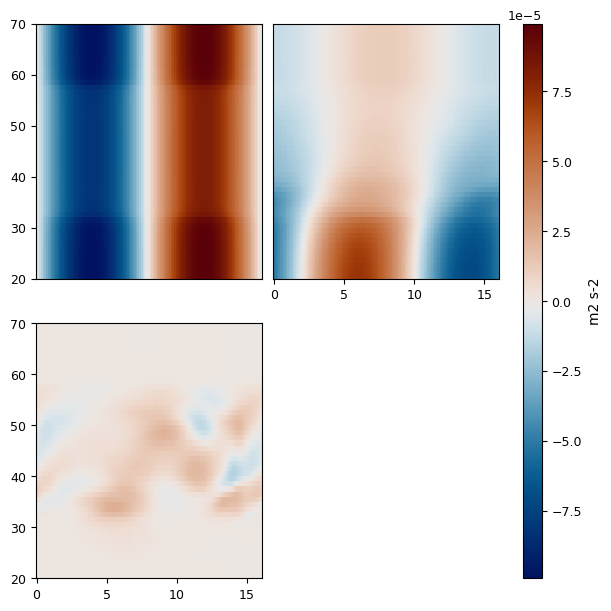

In [22]:
(fig_width_in, fig_height_in), _ = get_figure_dimensions("single", aspect_ratio=1)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))
axd = fig.subplot_mosaic(
    [
        ["0", "1", "cb"],
        ["2", "C", "cb"],
    ],
    width_ratios=[12, 12, 1],
    #sharex=True,
    #sharey=True
)

    
terms = ["SS", "BS", "MFC"]
vmax = np.max([np.abs(dsH_Sp[term]).quantile(0.98) for term in terms])
tdays = dsH_Sp.time / np.timedelta64(1,"D")

axes = [axd[f"{i}"] for i in range(3)]
for term, ax in zip(terms, axes):
    cm = ax.pcolormesh(tdays, equivY, dsH_Sp[term].T, vmin=-vmax, 
                  vmax=vmax, 
                  cmap=palette["cmdiv"]
                  )

axd["0"].set_xticks([])
#axd["1"].set_xticks([])
axd["1"].set_yticks([])
axd["C"].axis("off")

fig.colorbar(cm, cax=axd["cb"], label="m2 s-2")

fig.savefig(figpath+"Hmomentum_terms_S.pdf", bbox_inches="tight")

## Analysis on cartesian contours

In [23]:
# interpolate relevant variables to center position
dsY_L = interp_ds(ds_L, params_L, ["u", "v", "forcing_x", "detadx", "duvhdy"])
dsY_S = interp_ds(ds_S, params_S, ["u", "v", "forcing_x", "detadx", "duvhdy"])

dsY_L= dsY_L.isel(time=slice(focus_time_start_L,focus_time_stop_L))
dsY_S = dsY_S.isel(time=slice(focus_time_start_S,focus_time_stop_S))

#adjust time index so that t=0 is the beginning of the focus period
dsY_L["time"] = dsY_L.time - dsY_L.time.isel(time=0)
dsY_S["time"] = dsY_S.time - dsY_S.time.isel(time=0)

In [24]:
for dsY, params in zip([dsY_L, dsY_S], [params_L, params_S]):
    dsY["circulation"] = dsY.u.mean("xC")
    dsY["uH"] = (dsY.u*dsY.bath).mean("xC")
    dsY["BS"] = -(dsY.u).mean("xC")*params["R"]
    dsY["TFS"] = (-params["gravitational_acceleration"]*dsY.detadx*dsY.bath).mean("xC")
    dsY["MFC"] = (-dsY.duvhdy).mean("xC")
    dsY["SS"] = (dsY.forcing_x).mean("xC")

### Momentum diagrams

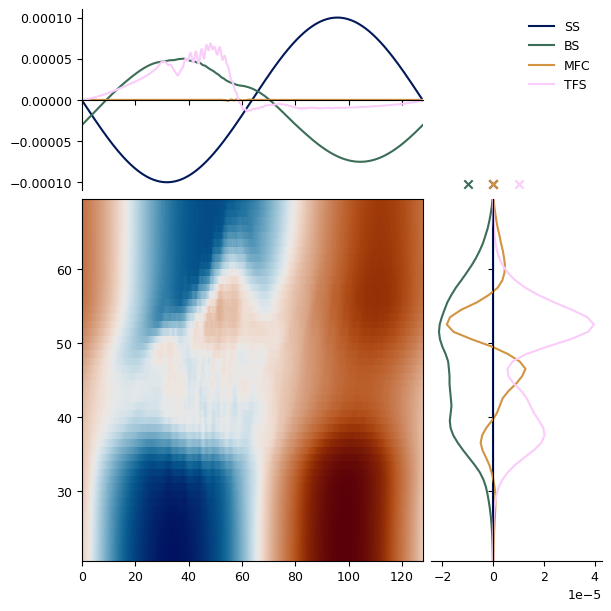

In [25]:
fig, axd = initialize_momentum_diagrams()

tdays = dsY_L.time / np.timedelta64(1, "D")
Y = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3 
vlim = np.max(np.abs(dsY_L.isel(yC=slice(ystart, ystop)).circulation))

axd["circ"].pcolormesh(tdays, Y,  dsY_L.isel(yC=slice(ystart, ystop)).circulation.T, 
                       vmin = -vlim,
                       vmax=vlim,
                       cmap=palette["cmdiv"]
                       )

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("time")
    axd["tmean"].plot(tmean, Y, color=colorwheel[i])
    
    ymean = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("yC")
    axd["ymean"].plot(tdays, ymean, color=colorwheel[i])
    
    axd["legend"].plot([None, None], [None, None], label=term,color=colorwheel[i])
    
    ytmean = ymean.mean("time")
    axd["tmean"].scatter(ytmean, Y[-1]+2, marker="x",color=colorwheel[i], clip_on=False)

axd["tmean"].set_ylim(Y[0], Y[-1])

axd["legend"].axis("off")
axd["legend"].legend(loc='upper right', 
                    frameon=False,
                    #ncols=2
                )
    
    
fig.savefig(figpath+"Ymomentum_L.pdf", bbox_inches="tight")

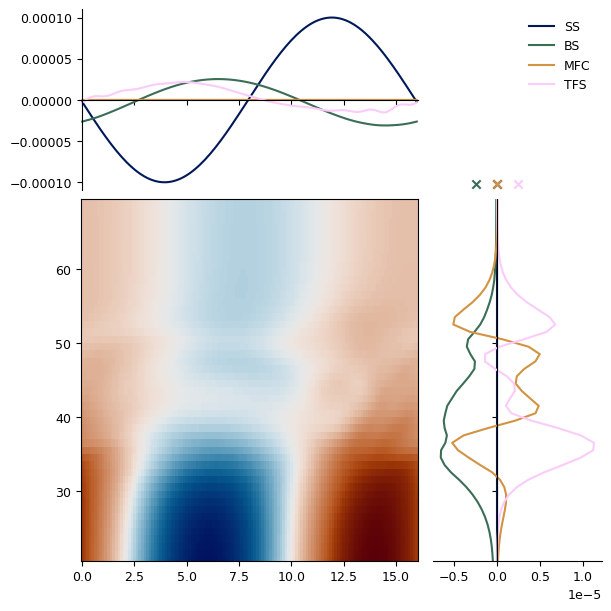

In [26]:
fig, axd = initialize_momentum_diagrams()

dsY_Sp = dsY_S.isel(time=slice(-16*8-1, None),yC=slice(ystart, ystop))
dsY_Sp["time"] = dsH_Sp["time"]-dsH_Sp["time"].isel(time=0)

tdays = dsY_Sp.time / np.timedelta64(1, "D")
Y = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3 
vlim = np.max(np.abs(dsY_Sp.circulation))

axd["circ"].pcolormesh(tdays, Y,  dsY_Sp.circulation.T, 
                       vmin = -vlim,
                       vmax=vlim,
                       cmap=palette["cmdiv"])

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean = dsY_Sp[term].mean("time")
    axd["tmean"].plot(tmean, Y, color=colorwheel[i])
    
    ymean = dsY_Sp[term].mean("yC")
    axd["ymean"].plot(tdays, ymean, color=colorwheel[i])
    #ymean = dsY_Sp[term].sel(yC=36500)
    #axd["ymean"].plot(tdays, ymean, color=colorwheel[i])
    
    axd["legend"].plot([None, None], [None, None], label=term,color=colorwheel[i])
    
    ytmean = ymean.mean("time")
    axd["tmean"].scatter(ytmean, Y[-1]+2, marker="x",color=colorwheel[i], clip_on=False)

axd["tmean"].set_ylim(Y[0], Y[-1])

axd["legend"].axis("off")
axd["legend"].legend(loc='upper right', 
                    frameon=False,
                    #ncols=2
                )

fig.savefig(figpath+"Ymomentum_S.pdf", bbox_inches="tight")

### Individual momentum terms

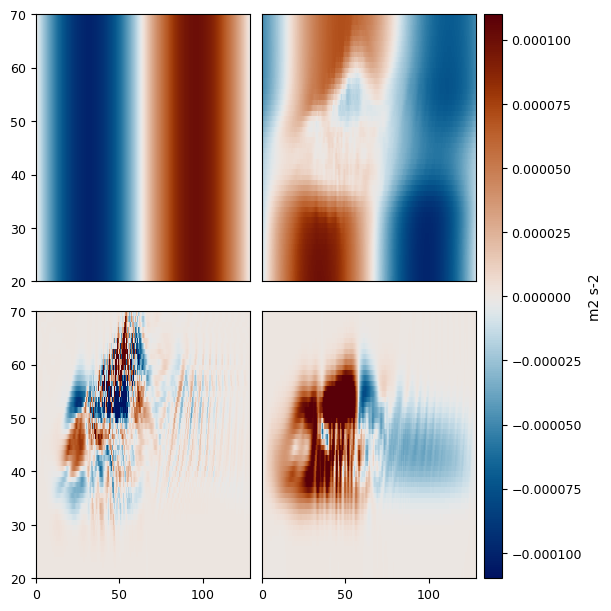

In [27]:
(fig_width_in, fig_height_in), _ = get_figure_dimensions("single", aspect_ratio=1)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))
axd = fig.subplot_mosaic(
    [
        ["0", "1", "cb"],
        ["2", "3", "cb"],
    ],
    width_ratios=[12, 12, 1],
    #sharex=True,
    #sharey=True
)

    
terms = ["SS", "BS", "MFC", "TFS"]
vmax = np.max([np.abs(dsY_L[term]).quantile(0.98) for term in terms])
tdays = dsY_L.time / np.timedelta64(1,"D")

axes = [axd[f"{i}"] for i in range(4)]
for term, ax in zip(terms, axes):
    cm = ax.pcolormesh(tdays, Y, dsY_L.isel(yC=slice(ystart,ystop))[term].T, vmin=-vmax, 
                  vmax=vmax, 
                  cmap=palette["cmdiv"]
                  )

axd["0"].set_xticks([])
axd["1"].set_xticks([])
axd["1"].set_yticks([])
axd["3"].set_yticks([])


fig.colorbar(cm, cax=axd["cb"], label="m2 s-2")

fig.savefig(figpath+"Ymomentum_terms_L.pdf", bbox_inches="tight")

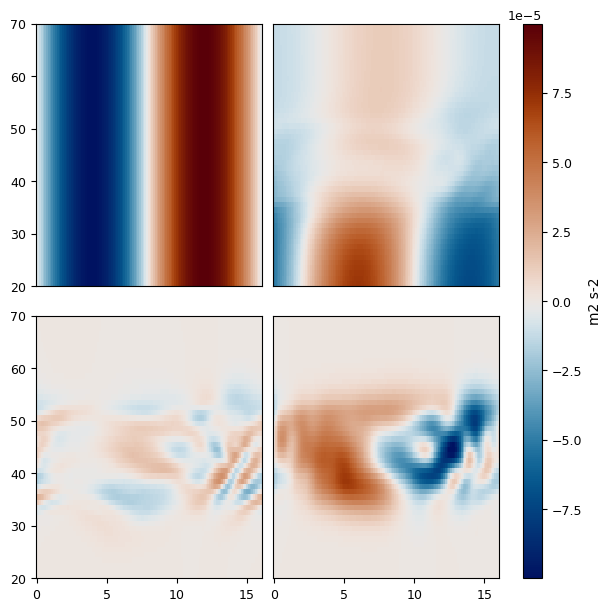

In [28]:
(fig_width_in, fig_height_in), _ = get_figure_dimensions("single", aspect_ratio=1)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))
axd = fig.subplot_mosaic(
    [
        ["0", "1", "cb"],
        ["2", "3", "cb"],
    ],
    width_ratios=[12, 12, 1],
    #sharex=True,
    #sharey=True
)

    
terms = ["SS", "BS", "MFC", "TFS"]
vmax = np.max([np.abs(dsY_Sp[term]).quantile(0.98) for term in terms])
tdays = dsY_Sp.time / np.timedelta64(1,"D")

axes = [axd[f"{i}"] for i in range(4)]
for term, ax in zip(terms, axes):
    cm = ax.pcolormesh(tdays, Y, dsY_Sp[term].T, vmin=-vmax, 
                  vmax=vmax, 
                  cmap=palette["cmdiv"]
                  )

axd["0"].set_xticks([])
axd["1"].set_xticks([])
axd["1"].set_yticks([])
axd["3"].set_yticks([])

fig.colorbar(cm, cax=axd["cb"], label="m2 s-2")

fig.savefig(figpath+"Ymomentum_terms_S.pdf", bbox_inches="tight")

## Topographic wave properties

### Arrest speed

In [29]:
def estimate_prograde_retrograde_speed(dsH,selection=slice(40,50)):
    slope = dsH.sel(j=selection).circulation
    #slope = dsH.sel(j=slice(40,50)).circulation
    
    retrograde = np.abs(np.min(slope))
    prograde = np.max(slope)
    
    return retrograde, prograde

In [30]:
# read simulation output
params_22km = load_config("../configs/varying_bathymetry/half.json")
ds_22km = read_raw_output(params_22km)
params_90km = load_config("../configs/varying_bathymetry/double.json")
ds_90km = read_raw_output(params_90km)

# interpolate dataset onto the selected depth-contours
dsH_22km = prepare_dsH(ds_22km, params_22km, H_targets)
dsH_90km = prepare_dsH(ds_90km, params_90km, H_targets)

for dsH, params in zip([dsH_22km, dsH_90km], [params_22km, params_90km]):
    # diagnose circulation
    dsH["circulation"] = mean_onH(dsH, variable="ui")

Loading configuration from ../configs/varying_bathymetry/half.json


Loading configuration from ../configs/varying_bathymetry/double.json


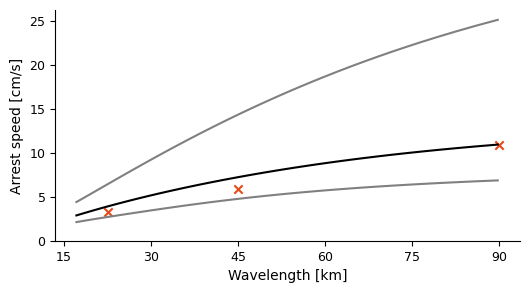

In [31]:
import scipy.io

fig, ax = create_figure("single"
                               )
customize_axis(ax, xzero=False)

for mode, color in zip([1, 2, 3], ["gray", "black", "gray"]):
    bwaves_data = scipy.io.loadmat(f"../output/raw/bwavesp_raw_outputs_mode{mode}_full.mat")
    rl = bwaves_data["rl"].flatten()  # wavenumber [rad/cm]
    ws = bwaves_data["ws"].flatten()  # frequency [rad/s]

    k = rl / 0.01                         # rad/cm → rad/m
    lambda_km = 2 * np.pi / k / 1000      # wavelength [km]
    c_phase_cmps = (ws / k) * 100

    ax.plot(lambda_km, c_phase_cmps, color=color)

#ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.set_xticks([15, 30, 45, 60, 75, 90])


ax.set_xlabel("Wavelength [km]")
ax.set_ylabel("Arrest speed [cm/s]")

for dsH, wl in zip([dsH_22km, dsH_L, dsH_90km], [22.5, 45, 90]):
    retrograde, prograde = estimate_prograde_retrograde_speed(dsH)
    ax.scatter(wl, retrograde*1e2, color=palette["accent1"], marker="x")
    
fig.savefig(figpath+"arrest_speed.pdf", bbox_inches="tight")
fig.savefig(figpath+"arrest_speed.png", transparent=True)


### Mode structure

In [32]:
# Load MATLAB file
bwaves_data = scipy.io.loadmat("../output/raw/bwavesp_raw_outputs_mode2_45km.mat")
x = bwaves_data["x"].flatten()
pp = bwaves_data["pp"].flatten()

In [33]:
eta = dsY_L["h"] - dsY_L["bath"]
etanod = eta - eta.mean(dim="xC")

etanod_neg = etanod.isel(time=slice(0,64*8))
etanod_pos = etanod.isel(time=slice(64*8,None))
etanod_pos["time"] = etanod_pos["time"] - etanod_pos["time"].isel(time=0)

mode = etanod_neg + etanod_pos 

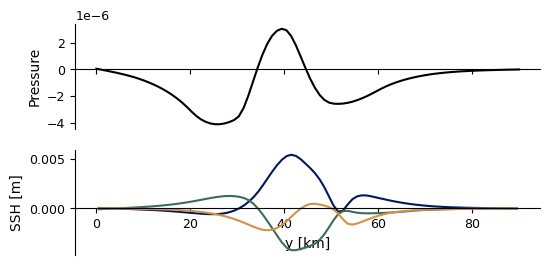

In [64]:
tidx = 30*8

fig, [axt,axb] = create_figure("single", 
                               nrows=2, 
                               sharex =True
                               )

customize_axis(axt, xzero=False)
customize_axis(axb, xzero=False)

ys = mode.yC/1e3

axt.plot(x/1e5, pp, color="black")

for i, xidx in enumerate([15,30,45]):
    modei = mode.isel(time=tidx, xC=xidx)
    axb.plot(ys, modei, color=colorwheel[i], label=f"x = {xidx} km")
    
#axb.legend()

axb.set_xlabel("y [km]")

axt.set_ylabel("Pressure")
axb.set_ylabel("SSH [m]")

# # Shift x-axis tick labels downward
# for label in axb.get_xticklabels():
#     label.set_y(label.get_position()[1] - 17e-4)


fig.savefig(figpath+"mode_structure.pdf", bbox_inches="tight")
fig.savefig(figpath+"mode_structure.png", transparent=True)



### Max speed as function of forcing strength

In [35]:
def hanning_filter(da, window_length = 6*8):
    # following http://xarray.pydata.org/en/stable/computation.html#rolling-window-operations
    hamming = np.hanning(window_length)
    window = xr.DataArray(hamming/np.sum(hamming), dims=['window'])
    rolling = da.rolling(time=window_length, center=True)
    filtered = rolling.construct(time='window').dot(window)

    
    return filtered    

In [36]:
depths_to_use = [H_targets[40], H_targets[45], H_targets[50]]

periods = ["short", "long"]
n_runs = 10 

# --- Pre-allocate a tidy xarray container ---
ds_out = xr.Dataset(
    coords=dict(
        period=("period", periods),
        run=("run", np.arange(1, n_runs + 1)),
        depth=("depth", depths_to_use),
    ),
    data_vars=dict(
        forcing_strength=(("period", "run"), np.full((len(periods), n_runs), np.nan)),
        prograde_max=(("period", "depth", "run"), np.full((len(periods), len(depths_to_use), n_runs), np.nan)),
        retrograde_max=(("period", "depth", "run"), np.full((len(periods), len(depths_to_use), n_runs), np.nan)),
        # Optional: you can stash other scalars here if useful later
        # e.g., eke_peak_time=(("period","depth","run"), np.nan) 
    ),
)

# --- Main loop (same number of experiments for both periods) ---
for p_idx, p in enumerate(periods):
    for r in range(1, n_runs + 1):
        params_i = load_config(f"../configs/varying_forcing/{p}_{r:03d}.json")
        forcing = params_i["tau0"]
        ds_i = read_raw_output(params_i).isel(time=slice(-128*8, None))

        # Prepare H-contour dataset for *three* depths
        dsH_i = prepare_dsH(ds_i, params_i, depths_to_use)

        # Mean circulation along H-contours; expect dims ('depth','time')
        circ = mean_onH(dsH_i, variable="ui")

        # Store filtered circulation back if your downstream functions use it;
        # ensure the filter keeps dims (depth, time). If your hanning_filter needs `dim="time"`, add it.
        dsH_i["circulation"] = hanning_filter(circ, window_length=2*8)

        # Save the forcing strength
        ds_out["forcing_strength"][p_idx, r - 1] = forcing

        # For each depth separately, compute pro/retro metrics
        # NOTE: 'selection=k' assumes estimate_* expects a depth index.
        for k, H in enumerate(dsH_i["depth"].values):
            retro, pro = estimate_prograde_retrograde_speed(dsH_i, selection=k)
            ds_out["prograde_max"][p_idx, k, r - 1]  = pro
            ds_out["retrograde_max"][p_idx, k, r - 1] = retro

# --- Convenience: sort by forcing strength along run dimension (optional but nice) ---
# This will independently sort runs for each period.
ds_sorted = ds_out.copy()
for p in periods:
    F = ds_out["forcing_strength"].sel(period=p)
    order = np.argsort(F.values)
    ds_sorted["forcing_strength"].loc[dict(period=p)] = F.values[order]
    for var in ["prograde_max", "retrograde_max"]:
        ds_sorted[var].loc[dict(period=p)] = ds_out[var].sel(period=p).values[..., order]


Loading configuration from ../configs/varying_forcing/short_001.json
Loading configuration from ../configs/varying_forcing/short_002.json
Loading configuration from ../configs/varying_forcing/short_003.json
Loading configuration from ../configs/varying_forcing/short_004.json
Loading configuration from ../configs/varying_forcing/short_005.json
Loading configuration from ../configs/varying_forcing/short_006.json
Loading configuration from ../configs/varying_forcing/short_007.json
Loading configuration from ../configs/varying_forcing/short_008.json
Loading configuration from ../configs/varying_forcing/short_009.json
Loading configuration from ../configs/varying_forcing/short_010.json
Loading configuration from ../configs/varying_forcing/long_001.json
Loading configuration from ../configs/varying_forcing/long_002.json
Loading configuration from ../configs/varying_forcing/long_003.json
Loading configuration from ../configs/varying_forcing/long_004.json
Loading configuration from ../configs/

In [51]:
ds_sorted = ds_sorted.isel(run=slice(0,8))

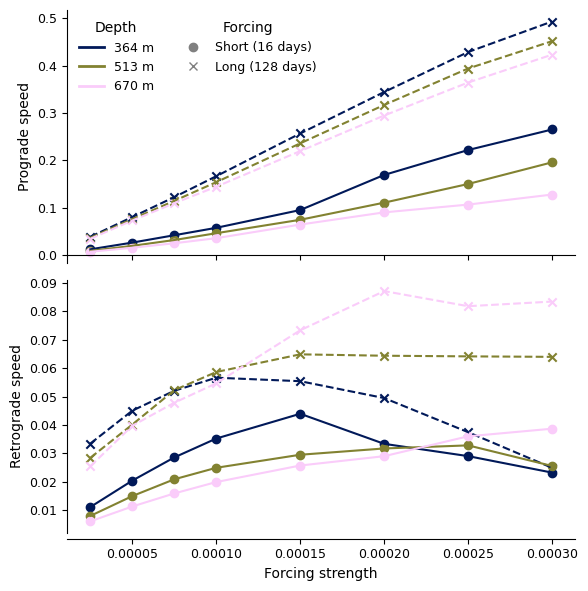

In [52]:
from matplotlib.lines import Line2D

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
customize_axis(ax1, xzero=False)
customize_axis(ax2, xzero=False)

# --- Color map across depths ---
depths = list(ds_sorted.depth.values)
cmap = palette["cmcat"]
colors = cmap(np.linspace(0, 1, len(depths)))
color_for = dict(zip(depths, colors))

# --- Plotting ---
for depth in depths:
    c = color_for[depth]

    # Prograde
    x_short = ds_sorted.forcing_strength.sel(period="short")
    y_short = ds_sorted.prograde_max.sel(period="short", depth=depth)
    ax1.plot(x_short, y_short, color=c, lw=1.5)
    ax1.scatter(x_short, y_short, color=c, marker="o")

    x_long = ds_sorted.forcing_strength.sel(period="long")
    y_long = ds_sorted.prograde_max.sel(period="long", depth=depth)
    ax1.plot(x_long, y_long, color=c, lw=1.5, ls="--")
    ax1.scatter(x_long, y_long, color=c, marker="x")

    # Retrograde
    y_short = ds_sorted.retrograde_max.sel(period="short", depth=depth)
    ax2.plot(x_short, y_short, color=c, lw=1.5)
    ax2.scatter(x_short, y_short, color=c, marker="o")

    y_long = ds_sorted.retrograde_max.sel(period="long", depth=depth)
    ax2.plot(x_long, y_long, color=c, lw=1.5, ls="--")
    ax2.scatter(x_long, y_long, color=c, marker="x")

# --- Legends ---
# Depth legend (colors only)
depth_handles = [
    Line2D([0], [0], color=color_for[d], lw=2, label=f"{int(d)} m")
    for d in depths
]

# Forcing legend (symbols only, in grey)
forcing_handles = [
    Line2D([0], [0], marker="o", color="grey", linestyle="None", label="Short (16 days)"),
    Line2D([0], [0], marker="x", color="grey", linestyle="None", label="Long (128 days)"),
]

leg_depths = ax1.legend(handles=depth_handles, title="Depth", frameon=False, loc="upper left")
leg_forcing = ax1.legend(handles=forcing_handles, title="Forcing",
                         frameon=False, loc="upper left", bbox_to_anchor=(0.2, 1.0))
ax1.add_artist(leg_depths)

# Labels
ax1.set_ylabel("Prograde speed")
ax2.set_ylabel("Retrograde speed")
ax2.set_xlabel("Forcing strength")

fig.tight_layout()
fig.savefig(figpath+"increasing_forcing.pdf", bbox_inches="tight")

In [39]:
# forcing_strengths_short, forcing_strengths_long = [], []
# progrades_short, retrogrades_short = [], []
# progrades_long, retrogrades_long = [], []
# circ_short, circ_long = [], []
# circs_short, circs_long = [], []

# for length, stop in zip(["long", "short"], [10, 19]):
    
#     for i in np.arange(1, stop):
#         params_i = load_config(f"../configs/varying_forcing/{length}_{i:03d}.json")
#         forcing = params_i["tau0"]
        
#         ds_i = read_raw_output(params_i).isel(time=slice(-128*8, None))
#         dsH_i = prepare_dsH(ds_i, params_i, [H_targets[focus_j]])
#         circ = mean_onH(dsH_i, variable="ui")
#         dsH_i["circulation"] = hanning_filter(circ, window_length=2*8)
        
#         retro, pro = estimate_prograde_retrograde_speed(dsH_i, selection=0)
        
#         if length == "short":
#             forcing_strengths_short.append(forcing)
#             progrades_short.append(pro)
#             retrogrades_short.append(retro)
#             circ_short.append(circ)
#             circs_short.append(dsH_i.circulation)
#         else:
#             forcing_strengths_long.append(forcing)
#             progrades_long.append(pro)
#             retrogrades_long.append(retro)
#             circ_long.append(circ)
#             circs_long.append(dsH_i.circulation)

# forcing_strengths_short = np.array(forcing_strengths_short)
# forcing_strengths_long = np.array(forcing_strengths_long)

In [40]:
# fig, (ax_long, ax_short) = plt.subplots(2, 1, figsize=(8, 6))

# start = 0
# stop = 9

# # --- Long forcing ---
# for forcing, circ, circs in zip(forcing_strengths_long[start:stop], circ_long[start:stop], circs_long[start:stop]):
#     # grab the next color from the current cycle
#     color = ax_long._get_lines.get_next_color()
    
#     time = circ["time"] / np.timedelta64(1, "D")
#     ax_long.plot(time, circ, label=f"{forcing:g}", color=color)
#     ax_long.plot(time, circs, ls="--", color=color)

# ax_long.set_title("Long forcing")
# ax_long.set_ylabel("Circulation")
# ax_long.legend(title="τ₀", ncol=3, fontsize=8)

# # --- Short forcing ---
# for forcing, circ, circs in zip(forcing_strengths_short[start:stop], circ_short[start:stop], circs_short[start:stop]):
#     # grab the next color from the current cycle
#     color = ax_short._get_lines.get_next_color()
    
#     time = circ["time"] / np.timedelta64(1, "D")
#     ax_short.plot(time[8*8:24*8], circ[8*8:24*8], label=f"{forcing:g}", color=color)
#     ax_short.plot(time[8*8:24*8], circs[8*8:24*8], ls="--", color=color)
    

# ax_short.set_title("Short forcing")
# ax_short.set_ylabel("Circulation")
# ax_short.set_xlabel("Time [days]")
# ax_short.legend(title="τ₀", ncol=3, fontsize=8)

In [41]:
# # --- Plotting ---
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# customize_axis(ax1)
# customize_axis(ax2)

# # Prograde plot
# ax1.plot(forcing_strengths_short[start:stop], progrades_short[start:stop], "o-", label="Short", color=palette["accent1"])
# ax1.plot(forcing_strengths_long[start:stop], progrades_long[start:stop], "x--", label="Long", color=palette["accent2"])
# ax1.set_ylabel("Prograde speed")
# ax1.legend()

# # Retrograde plot
# ax2.plot(forcing_strengths_short[start:stop], retrogrades_short[start:stop], "o-", label="Short", color=palette["accent1"])
# ax2.plot(forcing_strengths_long[start:stop], retrogrades_long[start:stop], "x--", label="Long", color=palette["accent2"])
# ax2.set_ylabel("Retrograde speed")
# ax2.set_xlabel("Forcing strength")

## Eddy kinetick energy

In [42]:


def calc_eke_mke_global(ds, params, j, window):
    ds = interp_ds(ds, params, ["u", "v"])

    u = ds.u 
    v = ds.v
    H = ds.bath
    a = params["dx"]*params["dy"]

    umean = hanning_filter(u, window_length=window)
    vmean = hanning_filter(v, window_length=window)
    
    unod = u - umean 
    vnod = v - vmean 


    Unod2 = unod**2 * H * a
    Vnod2 = vnod**2 * H * a
    
    Umean2 = umean**2 * H * a
    Vmean2 = vmean**2 * H * a

    EKE = 0.5*(Unod2.sum(["yC", "xC"])+Vnod2.sum(["yC", "xC"]))
    MKE = 0.5*(Umean2.sum(["yC", "xC"])+Vmean2.sum(["yC", "xC"]))
    
    # Keep NaNs: mask times where filtered fields are NaN anywhere in space
    bad_t = umean.isnull().any(dim=("yC", "xC")) | vmean.isnull().any(dim=("yC", "xC"))
    
    EKE = EKE.where(~bad_t)
    MKE = MKE.where(~bad_t)
    
    return EKE, MKE

In [43]:


def calc_eke_mke_depth(dsH, params, j, window):
    ds = dsH.sel(j=j)

    u = ds.u 
    v = ds.v
    H = ds.bath
    a = params["dx"]*params["dy"]

    umean = hanning_filter(u, window_length=window)
    vmean = hanning_filter(v, window_length=window)
    
    unod = u - umean 
    vnod = v - vmean 
    
    unod2 = unod**2*ds.dl
    vnod2 = vnod**2*ds.dl
    
    umean2 = umean**2*ds.dl
    vmean2 = vmean**2*ds.dl
    
    EKE = 0.5*(unod2.sum("i")+vnod2.sum("i"))/ds.dl.sum("i")
    MKE = 0.5*(umean2.sum("i")+vmean2.sum("i"))/ds.dl.sum("i")

    
    # Keep NaNs: mask times where filtered fields are NaN anywhere in space
    bad_t = umean.isnull().any(dim=("i")) | vmean.isnull().any(dim=("i"))
    
    EKE = EKE.where(~bad_t)
    MKE = MKE.where(~bad_t)
    
    return EKE, MKE

In [44]:
focus_j = 45

# eke_L, mke_L = calc_eke_mke_global(ds_L, params_L, j=focus_j, window=15*8)
# eke_L = eke_L.isel(time=slice(focus_time_start_L, focus_time_stop_L))
# eke_L["time"] = eke_L.time - t0_L

eke_L, mke_L = calc_eke_mke_depth(dsH_L, params_L, j=focus_j, window=15*8)


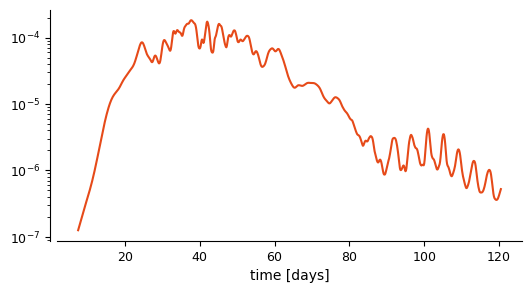

In [45]:
fig, ax = create_figure("single"
                               )
customize_axis(ax, yzero=False)

time = eke_L.time / np.timedelta64(1, "D")
ax.plot(time, eke_L, color=palette["accent1"], label="EKE")
ax.set_yscale("log")

# R = params_L["R"]
# depth = int(dsH_Ll.depth.sel(j=focus_j).values)

# # Find the maximum EKE and its corresponding time
# imax = eke_L.argmax().item()
# t0 = time.values[imax]
# eke0 = eke_L.values[imax]

# # Compute slope = -R/depth
# slope = -R/depth

# # Reference line: start at (t0, eke0) and decay with slope -R/depth
# t_ref = np.array([t0, time.max()])
# ref_line = eke0 * np.exp(slope * (t_ref - t0)*60*60*24)

# ax.plot(t_ref, ref_line, "--", color="k", 
#         label=fr"$\propto\exp(-Rt / {depth})$"
#         )
# ax.legend(borderaxespad=0,           # tighter to plot
#          frameon=False                # no border
#          ) 

ax.set_xlabel("time [days]")
ax.set_ylabel("")

fig.savefig(figpath+"EKE_dampening.pdf", bbox_inches="tight")

## No bumps

In [46]:
# # read simulation output
paramsnb_L = load_config("../configs/baseline_forcing/long_nobumps_crosswind.json")
dsnb_L = read_raw_output(paramsnb_L)
paramsnb_S = load_config("../configs/baseline_forcing/short_nobumps_crosswind.json")
dsnb_S = read_raw_output(paramsnb_S)

# # interpolate relevant variables to center position
dsYnb_L = interp_ds(dsnb_L, paramsnb_L, ["u", "v", "forcing_x", "detadx", "duvhdy"])
dsYnb_S = interp_ds(dsnb_S, paramsnb_S, ["u", "v", "forcing_x", "detadx", "duvhdy"])

dsYnb_L= dsYnb_L.isel(time=slice(focus_time_start_L,focus_time_stop_L))
dsYnb_S = dsYnb_S.isel(time=slice(-(16+8)*8,-8*8))

# #adjust time index so that t=0 is the beginning of the focus period
dsYnb_L["time"] = dsYnb_L.time - dsYnb_L.time.isel(time=0)
dsYnb_S["time"] = dsYnb_S.time - dsYnb_S.time.isel(time=0)

Loading configuration from ../configs/baseline_forcing/long_nobumps_crosswind.json
Loading configuration from ../configs/baseline_forcing/short_nobumps_crosswind.json


In [47]:
dsnb_L

<xarray.Dataset>
Dimensions:    (xC: 90, yF: 91, xF: 90, yC: 90, time: 3073)
Coordinates:
  * xC         (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yF         (yF) float64 0.0 1e+03 2e+03 3e+03 ... 8.8e+04 8.9e+04 9e+04
  * xF         (xF) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
  * yC         (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 384 days 00:00:00
Data variables: (12/14)
    v          (time, yF, xC) float64 ...
    duvhdy     (time, yF, xF) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zetau      (time, yF, xF) float64 ...
    zetav      (time, yF, xF) float64 ...
    u          (time, yC, xF) float64 0.0 0.0 0.0 ... -0.1003 -0.1003 -0.1003
    zeta       (time, yF, xF) float64 ...
    ...         ...
    bath       (yC, xC) float64 100.1 100.1 100.1 100.1 ... 899.9 899.9 899.9
    forcing_x  (time, yC, xC) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    forcing_y  (time, yC, xC) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    dx         (yC, xF) float64 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    dy         (yF, xC) float64 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    area       (yC, xC) float64 1e+06 1e+06 1e+06 1e+06 ... 1e+06 1e+06 1e+06
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.95.5
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-09-12T14:22:53.859.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

In [48]:
for dsY, params in zip([dsYnb_L, dsYnb_S], [paramsnb_L, paramsnb_S]):
    dsY["circulation"] = dsY.u.mean("xC")
    dsY["uH"] = (dsY.u*dsY.bath).mean("xC")
    dsY["BS"] = -(dsY.u).mean("xC")*params["R"]
    dsY["TFS"] = (-params["gravitational_acceleration"]*dsY.detadx*dsY.bath).mean("xC")
    dsY["MFC"] = (-dsY.duvhdy).mean("xC")
    dsY["SS"] = (dsY.forcing_x).mean("xC")

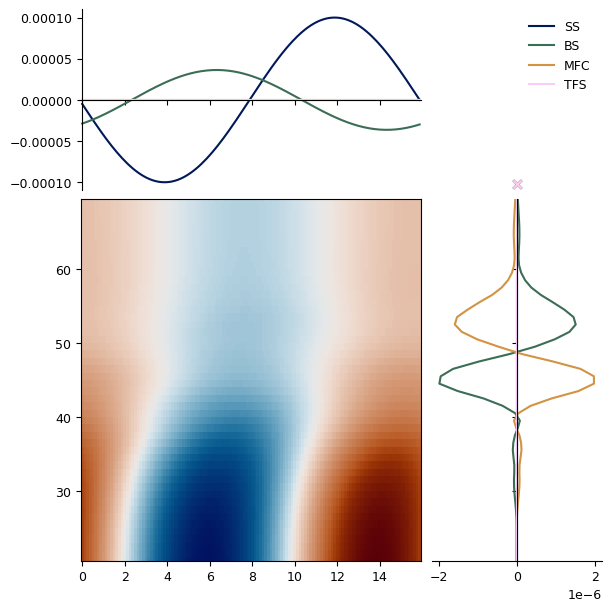

In [49]:
fig, axd = initialize_momentum_diagrams()

#dsYnb_Sp = dsYnb_S.isel(time=slice(-16*8-1, None))#,yC=slice(ystart, ystop))
dsYnb_Sp = dsYnb_S.isel(yC=slice(ystart, ystop))

#dsYnb_Sp["time"] = dsYnb_Sp["time"]-dsYnb_Sp["time"].isel(time=0)

tdays = dsYnb_Sp.time / np.timedelta64(1, "D")
Y = dsYnb_Sp.yC / 1e3 
vlim = np.max(np.abs(dsYnb_Sp.circulation))

axd["circ"].pcolormesh(tdays, Y,  dsYnb_Sp.circulation.T, 
                       vmin=-vlim,
                       vmax=vlim,
                       cmap=palette["cmdiv"])

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean = dsYnb_Sp[term].mean("time")
    axd["tmean"].plot(tmean, Y, color=colorwheel[i])
    
    ymean = dsYnb_S[term].mean("yC")
    axd["ymean"].plot(tdays, ymean, color=colorwheel[i])
    #ymean = dsY_Sp[term].sel(yC=36500)
    #axd["ymean"].plot(tdays, ymean, color=colorwheel[i])
    
    axd["legend"].plot([None, None], [None, None], label=term,color=colorwheel[i])
    
    ytmean = ymean.mean("time")
    axd["tmean"].scatter(ytmean, Y[-1]+2, marker="x",color=colorwheel[i], clip_on=False)

axd["tmean"].set_ylim(Y[0], Y[-1])

axd["legend"].axis("off")
axd["legend"].legend(loc='upper right', 
                    frameon=False,
                    #ncols=2
                )

fig.savefig(figpath+"momentum_nobumps_S.pdf", bbox_inches="tight")

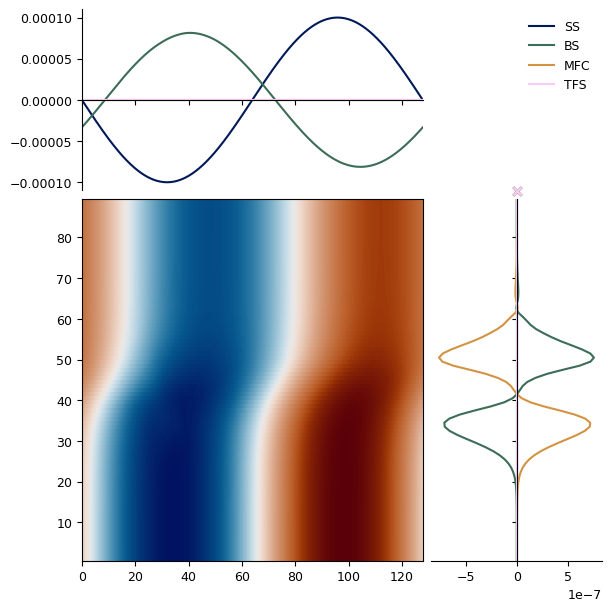

In [50]:
fig, axd = initialize_momentum_diagrams()

dsYnb_Lp = dsYnb_L#.isel(yC=slice(ystart, ystop))
dsYnb_Lp["time"] = dsYnb_Lp["time"]-dsYnb_Lp["time"].isel(time=0)

tdays = dsYnb_Lp.time / np.timedelta64(1, "D")
Y = dsYnb_Lp.yC / 1e3 

vlim = np.max(np.abs(dsYnb_Lp.circulation))
axd["circ"].pcolormesh(tdays, Y,  dsYnb_Lp.circulation.T, 
                       vmin=-vlim,
                       vmax=vlim,
                       cmap=palette["cmdiv"])

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean = dsYnb_Lp[term].mean("time")
    axd["tmean"].plot(tmean, Y, color=colorwheel[i])
    
    ymean = dsYnb_Lp[term].mean("yC")
    axd["ymean"].plot(tdays, ymean, color=colorwheel[i])
    #ymean = dsY_Sp[term].sel(yC=36500)
    #axd["ymean"].plot(tdays, ymean, color=colorwheel[i])
    
    axd["legend"].plot([None, None], [None, None], label=term,color=colorwheel[i])
    
    ytmean = ymean.mean("time")
    axd["tmean"].scatter(ytmean, Y[-1]+2, marker="x",color=colorwheel[i], clip_on=False)

axd["tmean"].set_ylim(Y[0], Y[-1])

axd["legend"].axis("off")
axd["legend"].legend(loc='upper right', 
                    frameon=False,
                    #ncols=2
                )

fig.savefig(figpath+"momentum_nobumps_L.pdf", bbox_inches="tight")